In [535]:
# CMPS140 Project - How to Become Top Earner in Airbnb?
# Tangni Wang, Tung Hoi Man, Yunxiang Fu
# {twang63, tuman, yfu7}@ucsc.edu

In [536]:
# To do:

# Split Training set, testing set in code?
# Convert attributes to numbers
# Generate graph
# Different model with different functions? Which function do we use?


In [537]:
import warnings
warnings.simplefilter("ignore")

import sklearn # sci-kit learn
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [538]:
# Helper functions
def correction(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

def correction2(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_int(x):
    '''
    Columns value corrections
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

# def changeTime(x):
#     '''
#     change host_response_time columns from string into numerical.
#     '''
#     if x == 'within an hour':
#         x=x.replace('within an hour', '1')
#     elif x == 'within a few hours':
#         x=x.replace('within a few hours', '4')
#     elif x == 'within a day':
#         x=x.replace('within a day', '24')
#     elif x == 'a few days or more':
#         x=x.replace('a few days or more', '48')
#     else:
#         x='96'
        
#     return int(x)

def changeTime(x):
    '''
    change host_response_time columns from string into numerical.
    '''
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'
        
    return x

def convertPolicy(x):
    '''
    Convert cancellation_policy columns from string into numerical.
    '''
    if x == 'strict':
        x=x.replace('strict', '1')
    elif x == 'moderate':
        x=x.replace('moderate', '3')
    elif x == 'flexible':
        x=x.replace('flexible', '5')
    else:
        x='3'
        
    return int(x)

In [539]:
# Parsing csv file
seattle_file_path = 'seattle_data/listings.csv'
seattle_data = pd.read_csv(seattle_file_path)
seattle_data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [540]:
# Make a new attribute for prediction
# seattle_data_new = seattle_data.copy()
seattle_data['new_score_reviews'] = seattle_data['reviews_per_month'] * seattle_data['review_scores_rating'] / 10
# seattle_data.describe()

In [541]:
# Define top performers and low performers
top90flag = seattle_data['new_score_reviews'].quantile(0.9)
upto25flag = seattle_data['new_score_reviews'].quantile(0.25)

seattle_data['top90'] = seattle_data.new_score_reviews >= top90flag
seattle_data['upto25'] = seattle_data.new_score_reviews <= upto25flag

print('The boundaries of top performer listings:', top90flag)
print('The boundaries of low performer listings:', upto25flag)

The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001


In [542]:
# Data Processing for training set

# # Drop useless columns
# useless_colmuns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
#     'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
#     'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
#     'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
#     'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'street', 
#     'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market',
#     'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
#     'room_type', 'bed_type', 'amenities', 'square_feet', 'guests_included', 'maximum_nights', 'calendar_updated', 
#     'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
#     'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 
#     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
#     'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 
#     'require_guest_phone_verification', 'calculated_host_listings_count', 'review_scores_rating', 'reviews_per_month'
# ]
# seattle_data.drop(useless_colmuns, axis=1)

# Remove $: price, weekly_price, security_deposit, extra_people, cleaning_fee
seattle_data['price']=seattle_data['price'].map(lambda x: correction(x))
seattle_data['weekly_price'] = seattle_data['weekly_price'].map(lambda x: correction(x))
seattle_data['monthly_price'] = seattle_data['monthly_price'].map(lambda x: correction(x))
seattle_data['security_deposit'] = seattle_data['security_deposit'].map(lambda x: correction(x))
seattle_data['extra_people'] = seattle_data['extra_people'].map(lambda x: correction(x))
seattle_data['cleaning_fee'] = seattle_data['cleaning_fee'].map(lambda x: correction(x))

# Convert string to number: host_response_time, cancellation_policy
seattle_data['host_response_time'] = seattle_data['host_response_time'].apply(changeTime).astype(int)
seattle_data['cancellation_policy'] = seattle_data['cancellation_policy'].map(lambda x: convertPolicy(x))

# Convert boolean t/f to int 1/0: host_is_superhost, host_identity_verified, instant_bookable
for i in seattle_data.columns:
    
    if set(seattle_data[i])=={'t','f'}:
        seattle_data[i]=seattle_data[i].apply(to_int)
        
    elif set(seattle_data[i]) == {'t','f',np.nan}:
        seattle_data[i]=seattle_data[i].apply(to_int)

# Fill missing value with reasonable values like 0 or 1.
seattle_data['new_score_reviews'].fillna(0, inplace = True)
seattle_data['accommodates'].fillna(0, inplace = True)
seattle_data['bathrooms'].fillna(0, inplace = True)
seattle_data['beds'].fillna(0, inplace = True)
seattle_data['price'].fillna(0, inplace = True)
seattle_data['weekly_price'].fillna(0, inplace = True)
seattle_data['monthly_price'].fillna(0, inplace = True)
seattle_data['security_deposit'].fillna(0, inplace = True)
seattle_data['cleaning_fee'].fillna(0, inplace = True)
seattle_data['extra_people'].fillna(0, inplace = True)
seattle_data['minimum_nights'].fillna(1, inplace = True)

# Features
seattle_features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy'
                    ]

# Drop rows if any feature still has missing value
seattle_data = seattle_data[seattle_features].dropna()

# print(seattle_data_pro)

In [552]:
# Needed features:
# ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
#                     'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
#                     'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
#                     'cancellation_policy'
#                     ]

X = seattle_data[seattle_features]

# Statistic of seattle features
# X
X.describe()

,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,host_response_time,host_is_superhost,host_identity_verified,instant_bookable,cancellation_policy
count,3818.000000,3818.000000,3812.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,3.349398,1.254191,1.307712,1.734940,127.976166,414.892614,1038.352803,140.566003,45.062860,10.667627,2.369303,18.838135,0.203772,0.784966,0.154793,2.860136
std,1.977599,0.594724,0.883395,1.139677,90.250022,551.477118,1677.470398,237.387534,49.913798,17.585922,16.305902,32.020666,0.402854,0.410900,0.361755,1.634168
min,1.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,3.000000,1.000000,1.000000,1.000000,100.000000,262.000000,0.000000,0.000000,30.000000,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,3.000000
75%,4.000000,1.000000,2.000000,2.000000,150.000000,671.500000,1890.000000,200.000000,65.000000,20.000000,2.000000,24.000000,0.000000,1.000000,0.000000,5.000000
max,16.000000,8.000000,7.000000,15.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,300.000000,1000.000000,96.000000,1.000000,1.000000,1.000000,5.000000


In [553]:
# Prediction target
y = seattle_data.new_score_reviews
# y
y.describe()

count    3818.000000
mean       16.495503
std        17.559186
min         0.000000
25%         2.800000
50%        10.288000
75%        25.177500
max       115.425000
Name: new_score_reviews, dtype: float64

In [562]:
# split training and testing set. Training = 80%. Testing = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3054, 17) (3054,)
(764, 17) (764,)


In [563]:
# Baseline model
# Make prediction by mean or median

# from sklearn.dummy import DummyRegressor

# # Create a dummy regressor
# baseline_model = DummyRegressor(strategy='mean')

# # "Train" dummy regressor
# baseline_model.fit(X_train, y_train)
# # print(dummy_mean)

# # Predict
# # print("Baseline model predicitions using testing set ")
# # print(X2.head())
# # print("The predictions are:")
# # print(baseline_model.predict(X_test))
# print("The score is:")
# print(baseline_model.score(X_test, y_test))

In [564]:
# Linear Regression
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print(model.score(X_test, y_test))

ValueError: could not convert string to float: '99\n98122'

ValueError: x and y must be the same size

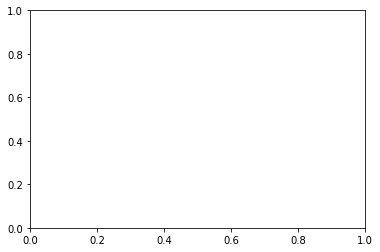

In [560]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [561]:
from sklearn.metrics import accuracy_score
y_test_pred = baseline_model.predict(X_test)
y_test.values.flatten()
accuracy_test = accuracy_score(y_test_pred, y_test)

ValueError: continuous is not supported